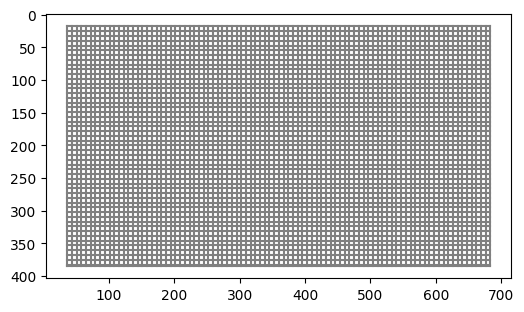

/home/shupeizhang/Codes/gst_python_plugin/python/warp.py:521: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky_AAt(t)


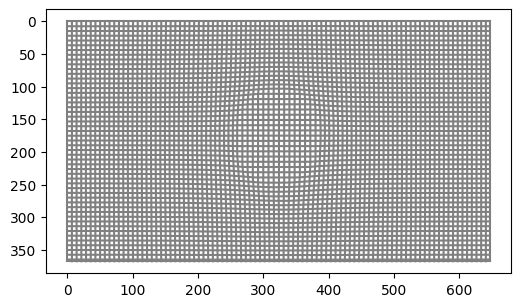

(368, 648, 3)

In [10]:
from warp import *
#sa = cv2.imread("/home/shupeizhang/Downloads/test/0012.png", cv2.IMREAD_GRAYSCALE)
#oi = cv2.imread("/home/shupeizhang/Downloads/test/image_0012.png")
sa = cv2.imread("/home/shupeizhang/data/home/shupeizhang/Codes/Datasets/saliency/UCF/training/Diving-Side-005/maps/Diving-Side_005_001.png", cv2.IMREAD_GRAYSCALE)
oi = cv2.imread("/home/shupeizhang/data/home/shupeizhang/Codes/Datasets/saliency/UCF/training/Diving-Side-005/images/Diving-Side_005_001.png")
oi = oi[:,:,::-1]
sa = cv2.resize(sa, (oi.shape[1], oi.shape[0]))
insize = (404, 720)
outsize = (368, 648)
threshold = 10
mask = sa >= threshold
g = Gaussian((404,720))
g.parameterize(sa, 10)
sa = g.build_map_from_params()
sa -= threshold
s = (outsize[0]/insize[0], outsize[1]/insize[1])
sa = sa.clip(1, 255)
scale = salient_scale(mask, insize, s)
w = lambda x, y: rescale2(x, *s, insize)
mesh = Mesh(sa, mask, outsize, 8, w)
mesh.V = mesh.warped_vertices
mesh.plot_mesh()
mesh.generate_mapping(5, insize, outsize, scale)
mesh.plot_mesh()
ot = mesh.coor_warping(oi)
ot.shape

In [8]:
import matplotlib.pyplot as plt
from PIL import Image

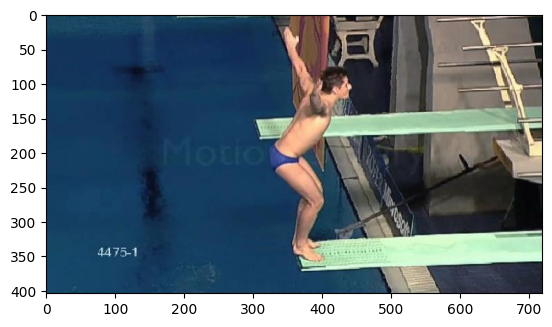

In [15]:
rp = mesh.reverse_warping(ot)
plt.imshow(rp)

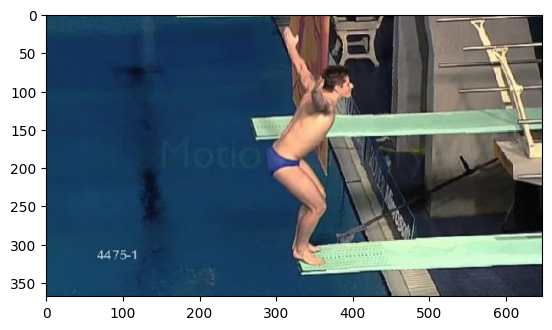

In [16]:
plt.imshow(ot)

In [89]:
def generate_gaussian_array(num_distributions, array_size, means, stds, weights=None):
    '''
    Generates a 2D array of multiple Gaussian distributions.

    Parameters:
    num_distributions (int): The number of Gaussian distributions to generate.
    array_size (tuple): The size of the 2D array to create.
    means (list): A list of length num_distributions containing the means of the Gaussian distributions.
    stds (list): A list of length num_distributions containing the standard deviations of the Gaussian distributions.
    weights (list): A list of length num_distributions containing the weights of the Gaussian distributions. If None, all weights are set to 1/num_distributions.

    Returns:
    numpy.ndarray: A 2D array of shape array_size containing the multiple Gaussian distributions.
    '''

    if weights is None:
        weights = [1/num_distributions] * num_distributions

    # Generate a random 2D array with the defined size
    random_array = np.random.rand(*array_size)

    # Compute the PDF of each distribution for each element in the 2D array
    pdfs = []
    for i in range(num_distributions):
        pdf = np.exp(-((np.arange(array_size[0])[:,np.newaxis]-means[i][0])**2/(2*stds[i][0]**2)+(np.arange(array_size[1])[np.newaxis,:]-means[i][1])**2/(2*stds[i][1]**2)))
        pdfs.append(pdf)

    # Multiply the PDF of each distribution by its corresponding weight (if applicable) and sum them up to obtain the final PDF of the element
    final_pdf = np.zeros(array_size)
    for i in range(num_distributions):
        final_pdf += weights[i] * pdfs[i]

    return final_pdf

def generate_noise_saliency_map(fixation_path, shift_range, sigma):
    fix = cv2.imread(fixation_path, cv2.IMREAD_GRAYSCALE)
    idx = [i for i in np.where(fix != 0)]
    idx[0] += np.random.randint(-shift_range, shift_range, idx[0].shape[0])
    idx[1] += np.random.randint(-shift_range, shift_range, idx[1].shape[0])
    means = np.vstack(idx).T
    stds = np.ones_like(means) * 40
    smap = generate_gaussian_array(idx[0].shape[0], fix.shape, means, stds, weights=None)
    smap = smap / smap.max() * 255
    smap = smap.clip(0, 255)
    return smap.astype(np.uint8)




def nss(prediction, ground_truth):
    """
    Compute NSS score.
        :param ground_truth : ground-truth fixation points(binary map)  4D tensor: (1, h, w)
        :param prediction : predicted saliency map, 4D tensor: (1, h, w)
        :return score: NSS score: tensor of (batch)
    """
    sal_map = prediction - prediction.mean(axis=(1, 2)).reshape((1, 1, 1))
    sal_map = sal_map / prediction.std(axis=(1, 2), ddof=1).reshape((1, 1, 1))
    sal_map = sal_map * (ground_truth > 0 )
    loss = sal_map.sum(axis=(1, 2)) / np.count_nonzero(ground_truth, axis=(1, 2))
    return loss

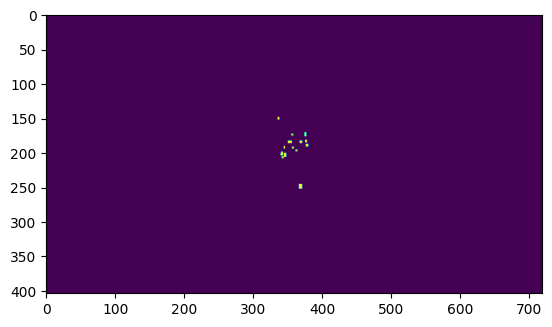

In [85]:
q1 = cv2.imread("/home/shupeizhang/data/home/shupeizhang/Codes/Datasets/saliency/UCF/training/Diving-Side-005/maps/Diving-Side_005_001.png", cv2.IMREAD_GRAYSCALE)
q2 = cv2.imread("/home/shupeizhang/data/home/shupeizhang/Codes/Datasets/saliency/UCF/training/Diving-Side-005/fixation/Diving-Side_005_001.png", cv2.IMREAD_GRAYSCALE)
q3 = (q1 - q1.mean())/q1.std()
nss(np.expand_dims(q1, 0), np.expand_dims(q2, 0))
plt.imshow(q2)

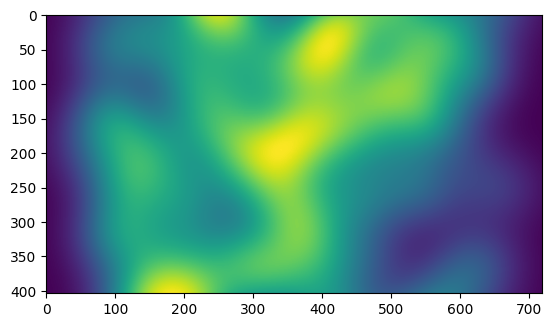

In [93]:
q2 = generate_noise_saliency_map("/home/shupeizhang/data/home/shupeizhang/Codes/Datasets/saliency/UCF/training/Diving-Side-005/fixation/Diving-Side_005_001.png", 300, 3)
plt.imshow(q2)

In [1]:
import cv2
oi = cv2.imread("../../Datasets/saliency/UCF/training/Diving-Side-005/images/Diving-Side_005_001.png")

In [9]:
import numpy as np
#lpips
results = []
with open('new_lpips_264_2.txt', 'r') as file:
    line = file.readline()
    line = file.readline()
    while line != '':
        c = line.split('\t')
        results.append((c[0], int(c[1]), float(c[2]), float(c[3])))
        line = file.readline()
# proposed, h264
scores = np.zeros((3, len(results)//7, 2))
for idx, i in enumerate(results):
    if idx%7 not in [4, 5, 6]:
        continue
    scores[idx%7 - 4, idx//7, 0] = i[2]
    scores[idx%7 - 4, idx//7, 1] = i[3]

print("LPIPS overall:\n{}\n".format(scores.mean(1)))
    
# scores of each category 
results2 = []
tmp = []
last = 'Diving'
cats = [last]
for idx, i in enumerate(results):
    if idx%7 != 0:
        continue
    if i[0].split('-')[0] == last:
        tmp.append(idx//7)
    else:
        results2.append(tmp)
        tmp = []
        tmp.append(idx//7)
        last = i[0].split('-')[0]
        cats.append(last)
print("LPIPS category:\n")  
for j, i in enumerate(results2):
    print(cats[j])
    print(scores[:,i,:].mean(axis=(1)))
for j, i in enumerate(results2):
    score_strs = []
    for m in range(3):
        if scores[:,i,:].mean(axis=1)[m,0] < scores[:,i,:].mean(axis=1)[m,1]:
            score_strs.append(r"""\textcolor{{red}}{{{:.4f}}}""".format(scores[:,i,:].mean(axis=1)[m,0]))
            score_strs.append(r"""{:.4f}""".format(scores[:,i,:].mean(axis=1)[m,1]))
        else:
            score_strs.append(r"""{:.4f}""".format(scores[:,i,:].mean(axis=1)[m,0]))
            score_strs.append(r"""\textcolor{{red}}{{{:.4f}}}""".format(scores[:,i,:].mean(axis=1)[m,1]))
            
    print(r"""    \multirow{{6}}{{*}}{{{}}} & \multirow{{2}}{{*}}{{\shortstack{{High}}}} & Proposed & {} \\
    \cline{{3-4}}
    & & H.264 & {} \\
    \cline{{2-4}}
    & \multirow{{2}}{{*}}{{\shortstack{{Medium}}}} & Proposed & {} \\
    \cline{{3-4}}
    & & H.264 & {} \\
    \cline{{2-4}}
    & \multirow{{2}}{{*}}{{\shortstack{{Low}}}} & Proposed & {} \\
    \cline{{3-4}}
    & & H.264 & {} \\
    \hline
    """.format(cats[j], 
               score_strs[0], score_strs[1], score_strs[2], score_strs[3], score_strs[4], score_strs[5],
              ))

LPIPS overall:
[[0.19222722 0.16781739]
 [0.27742127 0.32393299]
 [0.39870611 0.44152115]]

LPIPS category:

Diving
[[0.2194564  0.29716148]
 [0.31462157 0.51395527]
 [0.4394794  0.55856938]]
Golf
[[0.20494805 0.14252719]
 [0.29168694 0.22885736]
 [0.4008192  0.37849857]]
Kicking
[[0.17530431 0.17164759]
 [0.25880325 0.30726149]
 [0.37049685 0.46268931]]
Lifting
[[0.12387032 0.08812074]
 [0.19080167 0.32946426]
 [0.30937289 0.39136124]]
Riding
[[0.20065091 0.20690812]
 [0.28771511 0.35207621]
 [0.40184047 0.48754661]]
Run
[[0.1920049  0.22795955]
 [0.27129475 0.37875175]
 [0.38657332 0.47297053]]
SkateBoarding
[[0.23990692 0.16423543]
 [0.32203437 0.30640643]
 [0.4284168  0.45024357]]
Swing
[[0.18424462 0.13187588]
 [0.27550247 0.35729166]
 [0.4211163  0.46522408]]
    \multirow{6}{*}{Diving} & \multirow{2}{*}{\shortstack{High}} & Proposed & \textcolor{red}{0.2195} \\
    \cline{3-4}
    & & H.264 & 0.2972 \\
    \cline{2-4}
    & \multirow{2}{*}{\shortstack{Medium}} & Proposed & \text

In [14]:
#vmaf
results = []
with open('new_vmaf_265_2.txt', 'r') as file:
    line = file.readline()
    line = file.readline()
    while line != '':
        c = line.split('\t')
        results.append((c[0], int(c[1]), float(c[2]), float(c[3])))
        line = file.readline()
# proposed, h264
scores = np.zeros((3, len(results)//7, 2))
for idx, i in enumerate(results):
    if idx%7 not in [4, 5, 6]:
        continue
    scores[idx%7 - 4, idx//7, 0] = i[2]
    scores[idx%7 - 4, idx//7, 1] = i[3]

print("VMAF overall:\n{}\n".format(scores.mean(1)))
    
# scores of each category 
results2 = []
tmp = []
last = 'Diving-Side'
cats = [last]
for idx, i in enumerate(results):
    if idx%7 != 0:
        continue
    if i[0][:-4] == last:
        tmp.append(idx//7)
    else:
        results2.append(tmp)
        tmp = []
        tmp.append(idx//7)
        last = i[0][:-4]
        cats.append(last)
print("VMAF category:\n")  
for j, i in enumerate(results2):
    print(cats[j])
    print(scores[:,i,:].mean(axis=(1)))

VMAF overall:
[[43.98074491 60.30882705]
 [34.23645064 28.49714512]
 [18.67126178 13.23083738]]

VMAF category:

Diving-Side
[[51.3727935 56.9438428]
 [40.2692641 13.1048979]
 [23.4598844  6.0035189]]
Golf-Swing-Front
[[47.07060871 70.94774286]
 [38.56629686 52.23047486]
 [23.51150371 30.67278871]]
Golf-Swing-Side
[[40.8762666 65.7413148]
 [32.823848  35.8586202]
 [19.921094  22.587603 ]]
Kicking-Front
[[46.87581425 53.0186275 ]
 [35.20215775 23.09738425]
 [20.30828175  6.18537675]]
Kicking-Side
[[45.9149217 54.1884318]
 [34.4907498 20.3579746]
 [18.6762426  5.9452229]]
Lifting
[[41.1003925  68.86829775]
 [32.1467905  37.31500125]
 [14.477539    5.46436425]]
Riding-Horse
[[47.93072675 48.40723125]
 [35.190747   16.4829755 ]
 [19.07553975  8.87300075]]
Run-Side
[[50.51217611 52.03000044]
 [36.818841   19.51054856]
 [18.20045333  9.889219  ]]
SkateBoarding-Front
[[38.76355425 57.2977715 ]
 [31.26530388 24.59996975]
 [17.94192975 12.22148625]]
Swing-Bench
[[36.84294279 60.84185421]
 [29.2

In [33]:
from scipy.stats import binomtest
# subjective
results = []
with open('response.txt', 'r') as file:
    line = file.readline()
    while line != '':
        try:
            c = line.split('\t')
            int(c[2])
            results.append((c[1], int(c[2]), int(c[3])))
        except:
            pass
        line = file.readline()
scores = np.zeros((3, len(results)//3, 2))
# proposed, h264
for idx, i in enumerate(results):
    scores[idx%3, idx//3, 0] = i[2] == 1
    scores[idx%3, idx//3, 1] = i[2] == 0
print(np.sum(scores[0,:,0] == 1), np.sum(scores[0,:,0] == 0))

82 98


In [122]:
a = binomtest(72, 160, 0.5, "less")
print(a)
a.proportion_ci(0.99)

BinomTestResult(k=72, n=160, alternative='less', proportion_estimate=0.45, pvalue=0.11779121323463446)


ConfidenceInterval(low=0.0, high=0.5449121746605708)

0.26349864484456254
1.2501171231839218e-12
1.0524840112299973e-19


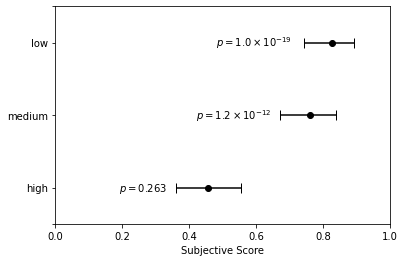

In [35]:
import matplotlib.pyplot as plt
errs = np.zeros((2, 3))
x = np.zeros(3)
for i in range(3):
    count = (np.sum(scores[i,:,0] == 1), np.sum(scores[i,:,0] == 0))
    mode = 'greater' if count[0] >= count[1] else 'less'
    t = binomtest(count[0], count[0] + count[1], 0.5)
    errs[0, i] = t.proportion_estimate - t.proportion_ci(0.99).low
    errs[1, i] = t.proportion_ci(0.99).high - t.proportion_estimate
    x[i] = t.proportion_estimate
    print(t.pvalue)
y = [1, 3, 5]
plt.figure()
plt.errorbar(x, y, xerr=errs, fmt = 'o', color = 'k', capsize=5)
plt.yticks((0, 1, 3, 5, 6), ('', 'high', 'medium', 'low','')) 
plt.xlim([0, 1])
plt.text(0.48, 4.9, r"$p = 1.0 \times 10^{-19}$")
plt.text(0.42, 2.9, r"$p = 1.2 \times 10^{-12}$")
plt.text(0.19, 0.9, r"$p=0.263$")
x
plt.xlabel('Subjective Score')
plt.savefig("binomial.pdf",bbox_inches='tight')

In [17]:
#EWPSNR
results = []
with open('new_ewpsnr_265.txt', 'r') as file:
    line = file.readline()
    while line != '':
        c = line.split('\t')
        results.append((c[0], int(c[1]), float(c[2]), float(c[3])))
        line = file.readline()
# proposed, h264
scores = np.zeros((3, len(results)//7, 2))
bitrate = np.zeros((3, len(results)//7, 2))
for idx, i in enumerate(results):
    if idx%7 not in [4, 5, 6]:
        continue
    scores[idx%7 - 4, idx//7, 1] = i[3] + 10 * np.log10(3)
    bitrate[idx%7 - 4, idx//7, 1] = i[2]
results = []
with open('new_ewpsnr_proposed_265.txt', 'r') as file:
    line = file.readline()
    while line != '':
        c = line.split('\t')
        results.append((c[0], int(c[1]), float(c[2]), float(c[3])))
        line = file.readline()
for idx, i in enumerate(results):
    if idx%7 not in [4, 5, 6]:
        continue
    scores[idx%7 - 4, idx//7, 0] = i[3]
    bitrate[idx%7 - 4, idx//7, 0] = i[2]

print("EWPSNR overall:\n{}\n".format(scores.mean(1)))
print("EWPSNR bitrate overall:\n{}\n".format(bitrate.mean(1)))

# scores of each category 
results2 = []
tmp = []
last = 'Diving-Side'
cats = [last]
for idx, i in enumerate(results):
    if idx%7 != 0:
        continue
    if i[0][:-4] == last:
        tmp.append(idx//7)
    else:
        results2.append(tmp)
        tmp = []
        tmp.append(idx//7)
        last = i[0][:-4]
        cats.append(last)
print("EWPSNR category:\n")  
for j, i in enumerate(results2):
    print(cats[j])
    print(scores[:,i,:].mean(axis=(1)))
    print(bitrate[:,i,:].mean(axis=(1)))

EWPSNR overall:
[[26.5176754  26.44246907]
 [25.73222778 25.29749534]
 [24.97567886 24.62236792]]

EWPSNR bitrate overall:
[[0.02390264 0.02288259]
 [0.0098776  0.00945388]
 [0.00436297 0.00587441]]

EWPSNR category:

Diving-Side
[[25.95625757 25.46374489]
 [25.16704695 24.36641135]
 [24.48729526 23.80844917]]
[[0.03439109 0.03236486]
 [0.01386108 0.0134869 ]
 [0.00663665 0.0097282 ]]
Golf-Swing-Front
[[29.05437775 29.89405667]
 [28.05429435 28.28171005]
 [27.10006355 27.24361759]]
[[0.0086348  0.00893317]
 [0.00386064 0.00406316]
 [0.00192196 0.0022588 ]]
Golf-Swing-Side
[[26.55816882 26.8819453 ]
 [25.84998661 25.54944657]
 [25.12430625 25.03557669]]
[[0.01948018 0.01911874]
 [0.00838546 0.00758347]
 [0.0037271  0.00458241]]
Kicking-Front
[[27.5804448  27.1626748 ]
 [26.74267707 25.94817341]
 [25.95728998 25.33037708]]
[[0.02026172 0.01951718]
 [0.00859046 0.00815651]
 [0.00383142 0.0050748 ]]
Kicking-Side
[[27.55695067 26.94417259]
 [26.58429169 25.73865094]
 [25.56598276 24.8609304

In [80]:
#Categories all methods table gen
import numpy as np
def lpips_gen(file_name):
    results = []
    with open(file_name, 'r') as file:
        line = file.readline()
        line = file.readline()
        while line != '':
            c = line.split('\t')
            results.append((c[0], int(c[1]), float(c[2]), float(c[3])))
            line = file.readline()
    # proposed, h264
    scores = np.zeros((3, len(results)//7, 2))
    for idx, i in enumerate(results):
        if idx%7 not in [4, 5, 6]:
            continue
        scores[idx%7 - 4, idx//7, 0] = i[2]
        scores[idx%7 - 4, idx//7, 1] = i[3]
    overall = scores.mean(1).copy()


    # scores of each category 
    results2 = []
    tmp = []
    last = 'Diving'
    cats = [last]
    for idx, i in enumerate(results):
        if idx%7 != 0:
            continue
        if i[0].split('-')[0] == last:
            tmp.append(idx//7)
        else:
            results2.append(tmp)
            tmp = []
            tmp.append(idx//7)
            last = i[0].split('-')[0]
            cats.append(last)
    category = {}
    for j, i in enumerate(results2):
        category[cats[j]] = scores[:,i,:].mean(axis=(1))
    return overall, category

def vmaf_gen(filename):
    results = []
    with open(filename, 'r') as file:
        line = file.readline()
        line = file.readline()
        while line != '':
            c = line.split('\t')
            results.append((c[0], int(c[1]), float(c[2]), float(c[3])))
            line = file.readline()
    # proposed, h264
    scores = np.zeros((3, len(results)//7, 2))
    for idx, i in enumerate(results):
        if idx%7 not in [4, 5, 6]:
            continue
        scores[idx%7 - 4, idx//7, 0] = i[2]
        scores[idx%7 - 4, idx//7, 1] = i[3]

    overall = scores.mean(1)

    # scores of each category 
    results2 = []
    tmp = []
    last = 'Diving'
    cats = [last]
    for idx, i in enumerate(results):
        if idx%7 != 0:
            continue
        if i[0].split('-')[0] == last:
            tmp.append(idx//7)
        else:
            results2.append(tmp)
            tmp = []
            tmp.append(idx//7)
            last = i[0].split('-')[0]
            cats.append(last)
    category = {}
    for j, i in enumerate(results2):
        category[cats[j]] = scores[:,i,:].mean(axis=(1))
    return overall, category

def ewpsnr_gen(filename1, filename2):
    results = []
    with open(filename1, 'r') as file:
        line = file.readline()
        while line != '':
            c = line.split('\t')
            results.append((c[0], int(c[1]), float(c[2]), float(c[3])))
            line = file.readline()
    # proposed, h264
    scores = np.zeros((3, len(results)//7, 2))
    bitrate = np.zeros((3, len(results)//7, 2))
    for idx, i in enumerate(results):
        if idx%7 not in [4, 5, 6]:
            continue
        scores[idx%7 - 4, idx//7, 1] = i[3]
        bitrate[idx%7 - 4, idx//7, 1] = i[2]
    results = []
    with open(filename2, 'r') as file:
        line = file.readline()
        while line != '':
            c = line.split('\t')
            results.append((c[0], int(c[1]), float(c[2]), float(c[3])))
            line = file.readline()
    for idx, i in enumerate(results):
        if idx%7 not in [4, 5, 6]:
            continue
        scores[idx%7 - 4, idx//7, 0] = i[3] + 10 * np.log10(3)
        bitrate[idx%7 - 4, idx//7, 0] = i[2]

    overall_perf = scores.mean(1)
    overall_bitrate = bitrate.mean(1)

    # scores of each category 
    results2 = []
    tmp = []
    last = 'Diving'
    cats = [last]
    for idx, i in enumerate(results):
        if idx%7 != 0:
            continue
        if i[0].split('-')[0] == last:
            tmp.append(idx//7)
        else:
            results2.append(tmp)
            tmp = []
            tmp.append(idx//7)
            last = i[0].split('-')[0]
            cats.append(last)
    category_perf = {}
    category_bitrate = {}
    for j, i in enumerate(results2):
        category_perf[cats[j]] = scores[:,i,:].mean(axis=(1))
        category_bitrate[cats[j]] = bitrate[:,i,:].mean(axis=(1))
    return overall_perf, overall_bitrate, category_perf, category_bitrate

lpips_all_264, lpips_cat_264 = lpips_gen('new_lpips_264_2.txt')
lpips_all_265, lpips_cat_265 = lpips_gen('new_lpips_265_2.txt')
vmaf_all_264, vmaf_cat_264 = vmaf_gen('new_vmaf_264_2.txt')
vmaf_all_265, vmaf_cat_265 = vmaf_gen('new_vmaf_265_2.txt')
ewpsnr_all_265_perf, ewpsnr_all_265_br, ewpsnr_cat_265, ewpsnr_cat_265_br = ewpsnr_gen('new_ewpsnr_265.txt', 'new_ewpsnr_proposed_265.txt')
ewpsnr_all_264_perf, ewpsnr_all_264_br, ewpsnr_cat_264, ewpsnr_cat_264_br = ewpsnr_gen('new_ewpsnr_264.txt', 'new_ewpsnr_proposed_264.txt')

tmp_264 = []
for i in range(3):
    score_strs = []
    if ewpsnr_all_264_perf[i, 0] > ewpsnr_all_264_perf[i, 1]:
        score_strs.append(r"""\textbf{{{:.4f}}}""".format(ewpsnr_all_264_perf[i, 0]))
        score_strs.append(r"""{:.4f}""".format(ewpsnr_all_264_perf[i, 1]))
    else:
        score_strs.append(r"""{:.4f}""".format(ewpsnr_all_264_perf[i, 0]))
        score_strs.append(r"""\textbf{{{:.4f}}}""".format(ewpsnr_all_264_perf[i, 1]))
    if lpips_all_264[i, 0] < lpips_all_264[i, 1]:
        score_strs.append(r"""\textbf{{{:.4f}}}""".format(lpips_all_264[i, 0]))
        score_strs.append(r"""{:.4f}""".format(lpips_all_264[i, 1]))
    else:
        score_strs.append(r"""{:.4f}""".format(lpips_all_264[i, 0]))
        score_strs.append(r"""\textbf{{{:.4f}}}""".format(lpips_all_264[i, 1]))
    if vmaf_all_264[i, 0] > vmaf_all_264[i, 1]:
        score_strs.append(r"""\textbf{{{:.4f}}}""".format(vmaf_all_264[i, 0]))
        score_strs.append(r"""{:.4f}""".format(vmaf_all_264[i, 1]))
    else:
        score_strs.append(r"""{:.4f}""".format(vmaf_all_264[i, 0]))
        score_strs.append(r"""\textbf{{{:.4f}}}""".format(vmaf_all_264[i, 1]))
    tmp_264.append(score_strs)


str_264 = r"""    \hline
    Bitrate & Method & EWPSNR & VMAF & LPIPS\\
    \hline
    \multirow{{2}}{{*}}{{\shortstack{{High\\{:.3f}bpp}}}} & Proposed & {} & {} & {}\\
    \cline{{2-5}}
    & H.264 & {} & {} & {}\\
    \hline
    \multirow{{2}}{{*}}{{\shortstack{{Medium\\{:.3f}bpp}}}} & Proposed & {} & {} & {}\\
    \cline{{2-5}}
    & H.264 & {} & {} & {}\\
    \hline
    \multirow{{2}}{{*}}{{\shortstack{{Low\\{:.3f}bpp}}}} & Proposed & {} & {} & {}\\
    \cline{{2-5}}
    & H.264 & {} & {} & {}\\
    \hline""".format(ewpsnr_all_264_br[0, 0], 
                     tmp_264[0][0], tmp_264[0][2], tmp_264[0][4],
                     tmp_264[0][1], tmp_264[0][3], tmp_264[0][5],
                     ewpsnr_all_264_br[1, 0], 
                     tmp_264[1][0], tmp_264[1][2], tmp_264[1][4],
                     tmp_264[1][1], tmp_264[1][3], tmp_264[1][5],
                     ewpsnr_all_264_br[2, 0], 
                     tmp_264[2][0], tmp_264[2][2], tmp_264[2][4],
                     tmp_264[2][1], tmp_264[2][3], tmp_264[2][5],
                    )

tmp_265 = []
for i in range(3):
    score_strs = []
    if ewpsnr_all_265_perf[i, 0] > ewpsnr_all_265_perf[i, 1]:
        score_strs.append(r"""\textbf{{{:.4f}}}""".format(ewpsnr_all_265_perf[i, 0]))
        score_strs.append(r"""{:.4f}""".format(ewpsnr_all_265_perf[i, 1]))
    else:
        score_strs.append(r"""{:.4f}""".format(ewpsnr_all_265_perf[i, 0]))
        score_strs.append(r"""\textbf{{{:.4f}}}""".format(ewpsnr_all_265_perf[i, 1]))
    if lpips_all_265[i, 0] < lpips_all_265[i, 1]:
        score_strs.append(r"""\textbf{{{:.4f}}}""".format(lpips_all_265[i, 0]))
        score_strs.append(r"""{:.4f}""".format(lpips_all_265[i, 1]))
    else:
        score_strs.append(r"""{:.4f}""".format(lpips_all_265[i, 0]))
        score_strs.append(r"""\textbf{{{:.4f}}}""".format(lpips_all_265[i, 1]))
    if vmaf_all_265[i, 0] > vmaf_all_265[i, 1]:
        score_strs.append(r"""\textbf{{{:.4f}}}""".format(vmaf_all_265[i, 0]))
        score_strs.append(r"""{:.4f}""".format(vmaf_all_265[i, 1]))
    else:
        score_strs.append(r"""{:.4f}""".format(vmaf_all_265[i, 0]))
        score_strs.append(r"""\textbf{{{:.4f}}}""".format(vmaf_all_265[i, 1]))
    tmp_265.append(score_strs)


str_265 = r"""    \hline
    Bitrate & Method & EWPSNR & LPIPS & VMAF\\
    \hline
    \multirow{{2}}{{*}}{{\shortstack{{High\\{:.3f}bpp}}}} & Proposed & {} & {} & {}\\
    \cline{{2-5}}
    & H.265 & {} & {} & {}\\
    \hline
    \multirow{{2}}{{*}}{{\shortstack{{Medium\\{:.3f}bpp}}}} & Proposed & {} & {} & {}\\
    \cline{{2-5}}
    & H.265 & {} & {} & {}\\
    \hline
    \multirow{{2}}{{*}}{{\shortstack{{Low\\{:.3f}bpp}}}} & Proposed & {} & {} & {}\\
    \cline{{2-5}}
    & H.265 & {} & {} & {}\\
    \hline""".format(ewpsnr_all_265_br[0, 0], 
                     tmp_265[0][0], tmp_265[0][2], tmp_265[0][4],
                     tmp_265[0][1], tmp_265[0][3], tmp_265[0][5],
                     ewpsnr_all_265_br[1, 0], 
                     tmp_265[1][0], tmp_265[1][2], tmp_265[1][4],
                     tmp_265[1][1], tmp_265[1][3], tmp_265[1][5],
                     ewpsnr_all_265_br[2, 0], 
                     tmp_265[2][0], tmp_265[2][2], tmp_265[2][4],
                     tmp_265[2][1], tmp_265[2][3], tmp_265[2][5],
                    )

#print(str_265)


cat_str = r"""    \hline
    Category & Bitrate & Method & EWPSNR & LPIPS & VMAF & Method & EWPSNR & LPIPS & VMAF\\
    \hline
    """
brs = ["High", "Medium", "Low"]
for cat in lpips_cat_264:
    temp_str = r"""\multirow{{6}}{{*}}{{{}}} """.format(cat)
    for br in range(3):
        score_strs = []
        if ewpsnr_cat_264[cat][br, 0] > ewpsnr_cat_264[cat][br, 1]:
            score_strs.append(r"""\textbf{{{:.4f}}}""".format(ewpsnr_cat_264[cat][br, 0]))
            score_strs.append(r"""{:.4f}""".format(ewpsnr_cat_264[cat][br, 1]))
        else:
            score_strs.append(r"""{:.4f}""".format(ewpsnr_cat_264[cat][br, 0]))
            score_strs.append(r"""\textbf{{{:.4f}}}""".format(ewpsnr_cat_264[cat][br, 1]))
        if lpips_cat_264[cat][br, 0] < lpips_cat_264[cat][br, 1]:
            score_strs.append(r"""\textbf{{{:.4f}}}""".format(lpips_cat_264[cat][br, 0]))
            score_strs.append(r"""{:.4f}""".format(lpips_cat_264[cat][br, 1]))
        else:
            score_strs.append(r"""{:.4f}""".format(lpips_cat_264[cat][br, 0]))
            score_strs.append(r"""\textbf{{{:.4f}}}""".format(lpips_cat_264[cat][br, 1]))
        if vmaf_cat_264[cat][br, 0] > vmaf_cat_264[cat][br, 1]:
            score_strs.append(r"""\textbf{{{:.4f}}}""".format(vmaf_cat_264[cat][br, 0]))
            score_strs.append(r"""{:.4f}""".format(vmaf_cat_264[cat][br, 1]))
        else:
            score_strs.append(r"""{:.4f}""".format(vmaf_cat_264[cat][br, 0]))
            score_strs.append(r"""\textbf{{{:.4f}}}""".format(vmaf_cat_264[cat][br, 1]))
        ################265
        if ewpsnr_cat_265[cat][br, 0] > ewpsnr_cat_265[cat][br, 1]:
            score_strs.append(r"""\textbf{{{:.4f}}}""".format(ewpsnr_cat_265[cat][br, 0]))
            score_strs.append(r"""{:.4f}""".format(ewpsnr_cat_265[cat][br, 1]))
        else:
            score_strs.append(r"""{:.4f}""".format(ewpsnr_cat_265[cat][br, 0]))
            score_strs.append(r"""\textbf{{{:.4f}}}""".format(ewpsnr_cat_265[cat][br, 1]))
            
        if lpips_cat_265[cat][br, 0] < lpips_cat_265[cat][br, 1]:
            score_strs.append(r"""\textbf{{{:.4f}}}""".format(lpips_cat_265[cat][br, 0]))
            score_strs.append(r"""{:.4f}""".format(lpips_cat_265[cat][br, 1]))
        else:
            score_strs.append(r"""{:.4f}""".format(lpips_cat_265[cat][br, 0]))
            score_strs.append(r"""\textbf{{{:.4f}}}""".format(lpips_cat_265[cat][br, 1]))
            
        if vmaf_cat_265[cat][br, 0] > vmaf_cat_265[cat][br, 1]:
            score_strs.append(r"""\textbf{{{:.4f}}}""".format(vmaf_cat_265[cat][br, 0]))
            score_strs.append(r"""{:.4f}""".format(vmaf_cat_265[cat][br, 1]))
        else:
            score_strs.append(r"""{:.4f}""".format(vmaf_cat_265[cat][br, 0]))
            score_strs.append(r"""\textbf{{{:.4f}}}""".format(vmaf_cat_265[cat][br, 1]))
        
        if br != 2:
            temp_str += r""" & \multirow{{2}}{{*}}{{\shortstack{{{}}}}} & 
    Proposed & {} & {} & {} & 
    Proposed & {} & {} & {} \\
    & & H.264 & {} & {} & {} & 
    H.265 & {} & {} & {}\\
    \cline{{2-10}}
    """.format(brs[br], score_strs[0], score_strs[2], score_strs[4], score_strs[6], score_strs[8], score_strs[10],
              score_strs[1], score_strs[3], score_strs[5], score_strs[7], score_strs[9], score_strs[11])
        else:
            temp_str += r""" & \multirow{{2}}{{*}}{{\shortstack{{{}}}}} & 
    Proposed & {} & {} & {} & 
    Proposed & {} & {} & {} \\
    & & H.264 & {} & {} & {} & 
    H.265 & {} & {} & {}\\
    \hline
    """.format(brs[br], score_strs[0], score_strs[2], score_strs[4], score_strs[6], score_strs[8], score_strs[10],
              score_strs[1], score_strs[3], score_strs[5], score_strs[7], score_strs[9], score_strs[11])
    cat_str += temp_str

print(str_265)



    \hline
    Bitrate & Method & EWPSNR & LPIPS & VMAF\\
    \hline
    \multirow{2}{*}{\shortstack{High\\0.024bpp}} & Proposed & \textbf{26.5177} & \textbf{0.1965} & 43.9807\\
    \cline{2-5}
    & H.265 & 26.4425 & 0.2167 & \textbf{60.3088}\\
    \hline
    \multirow{2}{*}{\shortstack{Medium\\0.010bpp}} & Proposed & \textbf{25.7322} & \textbf{0.2785} & \textbf{34.2365}\\
    \cline{2-5}
    & H.265 & 25.2975 & 0.3629 & 28.4971\\
    \hline
    \multirow{2}{*}{\shortstack{Low\\0.004bpp}} & Proposed & \textbf{24.9757} & \textbf{0.4071} & \textbf{18.6713}\\
    \cline{2-5}
    & H.265 & 24.6224 & 0.4510 & 13.2308\\
    \hline


In [72]:
#Entropy
with open("entropy.txt", 'r') as file:
    results = []
    line = file.readline()
    line = file.readline()
    while line != '':
        c = line.split('\t')
        results.append([c[0], int(c[1]), int(c[2]), float(c[3]), float(c[4]), float(c[5]), float(c[6])])
        line = file.readline()
    # epp, compressed_epp, total, toal_compressed
    scores = np.zeros((len(results), 4))
    for idx, item in enumerate(results):
        scores[idx] = np.array([*(item[3:7])])
    overall = scores.mean(axis=0)
        # scores of each category 
    results2 = []
    tmp = []
    last = 'Diving'
    cats = [last]
    for idx, i in enumerate(results):
        if i[0].split('-')[0] == last:
            tmp.append(idx)
        else:
            results2.append(tmp)
            tmp = []
            tmp.append(idx)
            last = i[0].split('-')[0]
            cats.append(last)
    category = {}
    for j, i in enumerate(results2):
        category[cats[j]] = scores[i,:].mean(axis=(0))
print(overall)
category

overall_str = r"""        \hline
        \shortstack{{Original Image\\Avg. Entropy}} & {:.4f} bpp\\
        \shortstack{{Warped Image\\Avg. Entropy}} & {:.4f} bpp\\
        \shortstack{{Original Image\\Total Entropy}} & {:.2E}\\
        \shortstack{{Warped Image\\Total Entropy}} & {:.2E}\\
        \hline""".format(*overall)
print(overall_str)
cat_str = r"""        \hline
        Category & \shortstack{Original Image\\Avg. Entropy} & \shortstack{Warped Image\\Avg. Entropy} & \shortstack{Original Image\\Total Entropy} & \shortstack{Warped Image\\Total Entropy}\\
        """
for i in category:
    cat_str += r"""{} & {:.4f} & {:.4f} & {:.2E} & {:.2E}\\
        """.format(i, category[i][0], category[i][1], category[i][2], category[i][3])
cat_str += r"""        \hline"""
print(cat_str)

[4.09068932e+00 4.41816408e+00 1.29332413e+06 6.95181093e+05]
        \hline
        \shortstack{Original Image\\Avg. Entropy} & 4.0907 bpp\\
        \shortstack{Warped Image\\Avg. Entropy} & 4.4182 bpp\\
        \shortstack{Original Image\\Total Entropy} & 1.29E+06\\
        \shortstack{Warped Image\\Total Entropy} & 6.95E+05\\
        \hline
        \hline
        Category & \shortstack{Original Image\\Avg. Entropy} & \shortstack{Warped Image\\Avg. Entropy} & \shortstack{Original Image\\Total Entropy} & \shortstack{Warped Image\\Total Entropy}\\
        Diving & 3.9609 & 4.3063 & 1.15E+06 & 6.25E+05\\
        Golf & 4.1326 & 4.4383 & 1.53E+06 & 8.07E+05\\
        Kicking & 3.3032 & 3.6952 & 1.23E+06 & 6.81E+05\\
        Lifting & 3.4798 & 3.9251 & 1.01E+06 & 5.70E+05\\
        Riding & 3.8194 & 4.2289 & 1.37E+06 & 7.55E+05\\
        Run & 3.6260 & 4.0329 & 1.26E+06 & 7.02E+05\\
        SkateBoarding & 4.7379 & 4.9179 & 8.19E+05 & 4.23E+05\\
        Swing & 4.7583 & 4.9979 & 1.38E+06 

## New

In [112]:
import numpy as np
#lpips
results = []
with open('test/new_lpips_265_2.txt', 'r') as file:
    line = file.readline()
    line = file.readline()
    while line != '':
        c = line.split('\t')
        results.append((c[0], int(c[1]), float(c[2]), float(c[3])))
        line = file.readline()
# proposed, h264
scores = np.zeros((7, len(results)//7, 2))
for idx, i in enumerate(results):
    scores[idx%7, idx//7, 0] = i[2]
    scores[idx%7, idx//7, 1] = i[3]

print("LPIPS overall:\n{}\n".format(scores.mean(1)))
for i in scores.mean(1):
    print("{},{}".format(i[0], i[1]))
    
# scores of each category 
results2 = []
tmp = []
last = 'Diving'
cats = [last]
for idx, i in enumerate(results):
    if idx%7 != 0:
        continue
    if i[0].split('-')[0] == last:
        tmp.append(idx//7)
    else:
        results2.append(tmp)
        tmp = []
        tmp.append(idx//7)
        last = i[0].split('-')[0]
        cats.append(last)
print("LPIPS category:\n")  
for j, i in enumerate(results2):
    print(cats[j])
    print(scores[:,i,:].mean(axis=(1)))

LPIPS overall:
[[0.06388361 0.01506121]
 [0.07334518 0.04161687]
 [0.09330682 0.08590773]
 [0.11900095 0.13474518]
 [0.16444363 0.20354202]
 [0.24320576 0.34557197]
 [0.37195707 0.4373539 ]]

0.06388360585619524,0.015061212907029876
0.07334517647774474,0.04161686875215433
0.0933068233352263,0.08590772653957016
0.1190009518951467,0.13474518013665976
0.1644436330760567,0.20354202165476326
0.24320575522566304,0.34557196555785763
0.37195706873842815,0.4373539030841253
LPIPS category:

Diving
[[0.06151846 0.01899215]
 [0.07571733 0.05626721]
 [0.10706279 0.11260582]
 [0.13724044 0.16868068]
 [0.18254408 0.25387281]
 [0.27015007 0.44907259]
 [0.40958962 0.57116236]]
Golf
[[0.06215214 0.01273136]
 [0.07298156 0.04124401]
 [0.09646399 0.09434999]
 [0.1289004  0.14579552]
 [0.18329895 0.20357643]
 [0.2615016  0.31455127]
 [0.37227836 0.38918816]]
Kicking
[[0.0432731  0.02030853]
 [0.0560952  0.05432799]
 [0.07983675 0.10468007]
 [0.1069448  0.15492425]
 [0.15245    0.21995125]
 [0.22950073 0.33

In [118]:
#vmaf
results = []
with open('test/new_vmaf_264_2.txt', 'r') as file:
    line = file.readline()
    line = file.readline()
    while line != '':
        c = line.split('\t')
        results.append((c[0], int(c[1]), float(c[2]), float(c[3])))
        line = file.readline()
# proposed, h264
scores = np.zeros((7, len(results)//7, 2))
for idx, i in enumerate(results):
    scores[idx%7, idx//7, 0] = i[2]
    scores[idx%7, idx//7, 1] = i[3]

print("VMAF overall:\n{}\n".format(scores.mean(1)))
for i in scores.mean(1):
    print("{},{}".format(i[0], i[1]))
    
# scores of each category 
results2 = []
tmp = []
last = 'Diving-Side'
cats = [last]
for idx, i in enumerate(results):
    if idx%7 != 0:
        continue
    if i[0][:-4] == last:
        tmp.append(idx//7)
    else:
        results2.append(tmp)
        tmp = []
        tmp.append(idx//7)
        last = i[0][:-4]
        cats.append(last)
print("VMAF category:\n")  
for j, i in enumerate(results2):
    print(cats[j])
    print(scores[:,i,:].mean(axis=(1)))

VMAF overall:
[[63.12572633 99.23934574]
 [62.77004473 98.05473344]
 [61.18167157 91.99748489]
 [57.52000624 80.96436956]
 [49.21246943 62.02261033]
 [35.19445867 36.44018082]
 [17.17354519 18.91393979]]

63.12572633009712,99.23934573786411
62.77004472815534,98.05473343689322
61.18167157281557,91.99748489320389
57.520006242718445,80.96436956310676
49.212469427184445,62.022610330097116
35.194458669902914,36.44018081553398
17.17354519417476,18.91393978640777
VMAF category:

Diving-Side
[[72.9017723 99.9436292]
 [72.4775194 99.7656707]
 [70.4825274 96.7062515]
 [65.8638298 83.0142931]
 [55.588767  52.6009289]
 [39.0064687 23.5587245]
 [18.3902794 14.9228906]]
Golf-Swing-Front
[[64.081751   97.98634129]
 [63.72846271 96.271726  ]
 [62.51127657 89.31389057]
 [59.71900843 82.06290629]
 [53.42881071 72.35499014]
 [42.16150357 59.23982629]
 [24.55213243 35.36215914]]
Golf-Swing-Side
[[58.239877  98.8249958]
 [57.8961656 96.9711288]
 [56.6366772 89.5805938]
 [53.9712964 80.4008244]
 [47.4139326

In [108]:
#EWPSNR
results = []
with open('test/ewpsnr_264.txt', 'r') as file:
    line = file.readline()
    while line != '':
        c = line.split('\t')
        results.append((c[0], int(c[1]), float(c[2]), float(c[3])))
        line = file.readline()
# proposed, h264
scores = np.zeros((7, len(results)//7, 2))
bitrate = np.zeros((7, len(results)//7, 2))
for idx, i in enumerate(results):
    scores[idx%7, idx//7, 1] = i[3]
    bitrate[idx%7, idx//7, 1] = i[2]
results = []
with open('test/proposed_264.txt', 'r') as file:
    line = file.readline()
    while line != '':
        c = line.split('\t')
        results.append((c[0], int(c[1]), float(c[2]), float(c[3])))
        line = file.readline()
for idx, i in enumerate(results):
    scores[idx%7, idx//7, 0] = i[3] + 10 * np.log10(3)
    bitrate[idx%7, idx//7, 0] = i[2]

print("EWPSNR overall:\n{}\n".format(scores.mean(1)))
for i in scores.mean(1):
    print("{},{}".format(i[0], i[1]))
print("EWPSNR bitrate overall:\n{}\n".format(bitrate.mean(1)))
for i in bitrate.mean(1):
    print("{},{}".format(i[0], i[1]))

# scores of each category 
results2 = []
tmp = []
last = 'Diving-Side'
cats = [last]
for idx, i in enumerate(results):
    if idx%7 != 0:
        continue
    if i[0][:-4] == last:
        tmp.append(idx//7)
    else:
        results2.append(tmp)
        tmp = []
        tmp.append(idx//7)
        last = i[0][:-4]
        cats.append(last)
print("EWPSNR category:\n")  
for j, i in enumerate(results2):
    print(cats[j])
    print(scores[:,i,:].mean(axis=(1)))
    print(bitrate[:,i,:].mean(axis=(1)))

EWPSNR overall:
[[28.75509724 37.89339029]
 [28.4868369  33.31738707]
 [27.91764709 29.81870529]
 [27.26557135 28.18914301]
 [26.48260107 26.82613007]
 [25.69864234 25.59217417]
 [24.95209588 24.73173597]]

28.755097240160634,37.893390294979945
28.48683690172411,33.31738706991433
27.917647090396464,29.81870529306927
27.26557135176559,28.189143006012298
26.482601072554335,26.826130073043075
25.698642343619753,25.592174169012665
24.952095879645746,24.731735971248668
EWPSNR bitrate overall:
[[1.08196832 1.03175692]
 [0.3885409  0.38384456]
 [0.1199929  0.12070892]
 [0.05256467 0.05320524]
 [0.0251318  0.02583046]
 [0.01305674 0.0134764 ]
 [0.00739019 0.00791517]]

1.0819683210005255,1.0317569240341655
0.38854089909912926,0.38384456255065974
0.11999289781763792,0.12070891871390578
0.05256466720820717,0.053205241174645194
0.02513180169325081,0.02583046071343904
0.01305673702983013,0.013476400714726184
0.007390187829437688,0.007915165798012722
EWPSNR category:

Diving-Side
[[28.76565784 36.4

In [87]:
#EWPSNR
results = []
with open('264_ewpsnr.txt', 'r') as file:
    line = file.readline()
    while line != '':
        c = line.split('\t')
        results.append((c[0], int(c[1]), float(c[2]), float(c[3])))
        line = file.readline()
# proposed, h264
scores = np.zeros((7, len(results)//7, 2))
bitrate = np.zeros((7, len(results)//7, 2))
for idx, i in enumerate(results):
    scores[idx%7, idx//7, 1] = i[3]
    bitrate[idx%7, idx//7, 1] = i[2]
results = []
with open('proposed_264.txt', 'r') as file:
    line = file.readline()
    while line != '':
        c = line.split('\t')
        results.append((c[0], int(c[1]), float(c[2]), float(c[3])))
        line = file.readline()
for idx, i in enumerate(results):
    scores[idx%7, idx//7, 0] = i[3]
    bitrate[idx%7, idx//7, 0] = i[2]

print("EWPSNR overall:\n{}\n".format(scores.mean(1)))
print("EWPSNR bitrate overall:\n{}\n".format(bitrate.mean(1)))

# scores of each category 
results2 = []
tmp = []
last = 'Diving-Side'
cats = [last]
for idx, i in enumerate(results):
    if idx%7 != 0:
        continue
    if i[0][:-4] == last:
        tmp.append(idx//7)
    else:
        results2.append(tmp)
        tmp = []
        tmp.append(idx//7)
        last = i[0][:-4]
        cats.append(last)
print("EWPSNR category:\n")  
for j, i in enumerate(results2):
    print(cats[j])
    print(scores[:,i,:].mean(axis=(1)))
    print(bitrate[:,i,:].mean(axis=(1)))

EWPSNR overall:
[[28.75509724 37.89339029]
 [28.4868369  33.31738707]
 [27.91764709 29.81870529]
 [27.26557135 28.18914301]
 [26.48260107 26.82613007]
 [25.69864234 25.59217417]
 [24.95209588 24.73173597]]

EWPSNR bitrate overall:
[[1.08196832 1.03175692]
 [0.3885409  0.38384456]
 [0.1199929  0.12070892]
 [0.05256467 0.05320524]
 [0.0251318  0.02583046]
 [0.01305674 0.0134764 ]
 [0.00739019 0.00791517]]

EWPSNR category:

Diving-Side
[[28.76565784 36.45078268]
 [28.38902552 31.89632801]
 [27.55807927 28.73155266]
 [26.74747725 27.12834944]
 [25.91810885 25.67689089]
 [25.20684561 24.5332548 ]
 [24.54122704 24.05202728]]
[[1.40369747 1.29904875]
 [0.56918609 0.5470514 ]
 [0.19699154 0.19998188]
 [0.08829799 0.08891474]
 [0.0424693  0.04402448]
 [0.02258378 0.02563146]
 [0.01344599 0.01635788]]
Golf-Swing-Front
[[31.31202925 40.98406989]
 [31.05322115 36.62131283]
 [30.49369043 32.95133834]
 [29.83974044 31.47430083]
 [29.03141416 30.15594209]
 [28.0445505  29.03310583]
 [26.7929565  27.